# Saving Model State


## Setup


In [1]:
import os
import sys
import time
import shutil

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import (
    Sequential,
    layers,
    optimizers,
    callbacks,
    regularizers,
    activations,
    losses,
    models,
)
import tensorflow_hub as hub


In [2]:
print(f"Tensorflow version: {tf.__version__}")

device_name = tf.test.gpu_device_name()
gpus = len(tf.config.list_physical_devices("GPU"))
gpus_text = f"{gpus} GPUs" if gpus > 1 else f"{gpus} GPU"
if device_name == "":
    BATCH_SIZE = 32
    raise SystemError("GPU device not found")
else:
    BATCH_SIZE = 1024
    print(f"Found {gpus_text} at: {device_name}")

os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "COMPRESSED"

Tensorflow version: 2.9.1
Found 1 GPU at: /device:GPU:0
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [3]:
!pwd

/Users/mmenendezg/Developer/Books/practical_ml_for_computer_vision/notebooks/chapter 7


In [4]:
functions_path = os.path.join("..", "..", "..", "functions")
sys.path.append(functions_path)
import learning_rate_functions as lrf

In [5]:
def get_logdir():
    run_id = "run_" + time.strftime("%Y%m%d_%H%M%S")
    logdir = os.path.join("..", "..", "logs", run_id)
    return logdir

In [6]:
IMG_HEIGHT = 448
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = [
    "daisy",
    "dandelion",
    "roses",
    "sunflowers",
    "tulips",
]
PATTERN_SUFFIX = "-*"
EPOCHS = 30
TRAIN_URL = "gs://practical-ml-vision-book/flowers_tfr/train-0000[01]-*"
VALID_URL = "gs://practical-ml-vision-book/flowers_tfr/valid-0000[01]-*"
MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
AUTOTUNE = tf.data.AUTOTUNE
GS_FILES = [
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/9158041313_7a6a102f7a_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg",
]

## Training Code


In [7]:
class _Preprocessor:
    def __init__(self):
        pass

    def read_from_tfr(self, proto):
        feature_description = {
            "image": tf.io.VarLenFeature(tf.float32),
            "shape": tf.io.VarLenFeature(tf.int64),
            "label": tf.io.FixedLenFeature([], tf.string, default_value=""),
            "label_int": tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(proto, feature_description)
        shape = tf.sparse.to_dense(rec["shape"])
        img = tf.reshape(tf.sparse.to_dense(rec["image"]), shape)
        label_int = rec["label_int"]
        return img, label_int

    def read_from_jpegfile(self, filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS)
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

    def preprocess(self, image):
        image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH)
        return image


In [8]:
files = [f for f in tf.io.gfile.glob(TRAIN_URL)]
for file in files:
    print(f'{file} -> {type(file)}')

gs://practical-ml-vision-book/flowers_tfr/train-00000-of-00016.gz -> <class 'str'>
gs://practical-ml-vision-book/flowers_tfr/train-00001-of-00016.gz -> <class 'str'>


In [9]:
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    files = [f for f in tf.io.gfile.glob(pattern)]
    if len(files) > 1:
        print(f"Interleaving the reading of {len(files)} files.")

        def _create_half_ds(x):
            if x == 0:
                half = files[: (len(files) // 2)]
            else:
                half = files[(len(files) // 2) :]
            return tf.data.TFRecordDataset(half, compression_type="GZIP")

        dataset = tf.data.Dataset.range(2).interleave(
            _create_half_ds, num_parallel_calls=AUTOTUNE
        )
    else:
        dataset = tf.data.TFRecordDataset(files, compression_type="GZIP")

    def _preproc_img_label(img, label):
        return (preproc.preprocess(img), label)

    dataset = (
        dataset.map(preproc.read_from_tfr, num_parallel_calls=AUTOTUNE)
        .map(_preproc_img_label, num_parallel_calls=AUTOTUNE)
        .shuffle(500)
        .prefetch(AUTOTUNE)
    )
    return dataset


def create_preproc_image(filename):
    preproc = _Preprocessor()
    image = preproc.read_from_jpegfile(filename)
    image = preproc.preprocess(image)
    return image

## Training


In [10]:
shutil.rmtree("checkpoints", ignore_errors=True)
os.mkdir("checkpoints")


def train_and_evaluate(
    lrate=0.001,
    l1=0.0,
    l2=0.0,
    num_hidden=16,
):
    with tf.device("/device:CPU:0"):
        data_augmentation = Sequential(
            [
                layers.RandomCrop(
                    height=IMG_HEIGHT // 2,
                    width=IMG_WIDTH // 2,
                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                    name="random/center_crop",
                ),
                layers.RandomFlip(mode="horizontal", name="random_lr_flip/none"),
                layers.RandomContrast(factor=0.2),
            ]
        )

    train_ds = (
        create_preproc_dataset(TRAIN_URL)
        .map(
            lambda image, label: (data_augmentation(image), label),
            num_parallel_calls=AUTOTUNE,
        )
        .batch(BATCH_SIZE)
    )
    valid_ds = (
        create_preproc_dataset(VALID_URL)
        .map(
            lambda image, label: (data_augmentation(image), label),
            num_parallel_calls=AUTOTUNE,
        )
        .batch(BATCH_SIZE)
    )

    # Layers
    regularizer = regularizers.l1_l2(l1, l2)
    layers_ = [
        hub.KerasLayer(
            MODEL_URL,
            trainable=False,
            input_shape=(IMG_HEIGHT // 2, IMG_WIDTH // 2, IMG_CHANNELS),
            name="mobilenet_embedding",
        ),
        layers.Dense(
            num_hidden,
            kernel_regularizer=regularizer,
            kernel_initializer="he_normal",
            activation=activations.elu,
            name="dense_hidden",
        ),
        layers.Dense(
            len(CLASS_NAMES),
            kernel_regularizer=regularizer,
            activation=activations.softmax,
            name="prob_flowers",
        ),
    ]

    # Callbacks
    exponential_decay_fn = lrf.exponential_decay_with_warmup(
        lr_start=lrate / 2,
        lr_max=lrate,
        lr_min=lrate / 10,
        lr_rampup_epochs=EPOCHS // 10,
        lr_sustain_epochs=EPOCHS // 5,
        lr_exp_decay=0.25,
    )
    lr_scheduler = callbacks.LearningRateScheduler(exponential_decay_fn)

    logdir = get_logdir()
    tensorboard_cb = callbacks.TensorBoard(log_dir=logdir)

    early_stop_cb = callbacks.EarlyStopping(
        patience=EPOCHS // 10, monitor="val_accuracy", mode="max"
    )
    model_checkpoint_cb = callbacks.ModelCheckpoint(
        filepath="./checkpoints/",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
    )
    callbacks_ = [
        lr_scheduler,
        tensorboard_cb,
        early_stop_cb,
        model_checkpoint_cb,
    ]

    # Training
    model = Sequential(layers_, name="flower_classifier")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lrate),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    print(model.summary())
    model.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=EPOCHS,
        callbacks=callbacks_,
    )
    
    return model


In [11]:
model = train_and_evaluate()

Interleaving the reading of 2 files.
Interleaving the reading of 2 files.
Model: "flower_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 prob_flowers (Dense)        (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/30
      1/Unknown - 22s 22s/step - loss: 1.7819 - accuracy: 0.2953INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 56s 56s/step - loss: 1.7819 - accuracy: 0.2953 - val_loss: 1.6624 - val_accuracy: 0.3679 - lr: 5.0000e-04
Epoch 2/30
1/1 [==============================] - 40s 40s/step - loss: 1.6738 - accuracy: 0.2897 - val_loss: 1.5377 - val_accuracy: 0.3627 - lr: 6.6667e-04
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 1.5900 - accuracy: 0.3175INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 49s 49s/step - loss: 1.5900 - accuracy: 0.3175 - val_loss: 1.4645 - val_accuracy: 0.3731 - lr: 8.3333e-04
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 1.3854 - accuracy: 0.4067INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 66s 66s/step - loss: 1.3854 - accuracy: 0.4067 - val_loss: 1.3345 - val_accuracy: 0.4689 - lr: 0.0010
Epoch 5/30
1/1 [==============================] - ETA: 0s - loss: 1.3239 - accuracy: 0.4429INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 49s 49s/step - loss: 1.3239 - accuracy: 0.4429 - val_loss: 1.2449 - val_accuracy: 0.5181 - lr: 0.0010
Epoch 6/30
1/1 [==============================] - ETA: 0s - loss: 1.2235 - accuracy: 0.5070INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 52s 52s/step - loss: 1.2235 - accuracy: 0.5070 - val_loss: 1.1827 - val_accuracy: 0.5544 - lr: 0.0010
Epoch 7/30
1/1 [==============================] - ETA: 0s - loss: 1.1388 - accuracy: 0.5543INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 58s 58s/step - loss: 1.1388 - accuracy: 0.5543 - val_loss: 1.0871 - val_accuracy: 0.5907 - lr: 0.0010
Epoch 8/30
1/1 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.6128INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 59s 59s/step - loss: 1.0481 - accuracy: 0.6128 - val_loss: 1.0671 - val_accuracy: 0.6010 - lr: 0.0010
Epoch 9/30
1/1 [==============================] - ETA: 0s - loss: 0.9873 - accuracy: 0.6657INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 58s 58s/step - loss: 0.9873 - accuracy: 0.6657 - val_loss: 1.0447 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 10/30
1/1 [==============================] - ETA: 0s - loss: 0.9473 - accuracy: 0.6490INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 57s 57s/step - loss: 0.9473 - accuracy: 0.6490 - val_loss: 0.9589 - val_accuracy: 0.6451 - lr: 0.0010
Epoch 11/30
1/1 [==============================] - ETA: 0s - loss: 0.9143 - accuracy: 0.6713INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 52s 52s/step - loss: 0.9143 - accuracy: 0.6713 - val_loss: 0.9581 - val_accuracy: 0.6658 - lr: 3.2500e-04
Epoch 12/30
1/1 [==============================] - 46s 46s/step - loss: 0.8919 - accuracy: 0.7103 - val_loss: 0.9693 - val_accuracy: 0.6347 - lr: 1.5625e-04
Epoch 13/30
1/1 [==============================] - ETA: 0s - loss: 0.8975 - accuracy: 0.6713INFO:tensorflow:Assets written to: ./checkpoints/assets


INFO:tensorflow:Assets written to: ./checkpoints/assets


1/1 [==============================] - 59s 59s/step - loss: 0.8975 - accuracy: 0.6713 - val_loss: 0.9215 - val_accuracy: 0.7047 - lr: 1.1406e-04
Epoch 14/30
1/1 [==============================] - 44s 44s/step - loss: 0.8877 - accuracy: 0.7019 - val_loss: 0.9363 - val_accuracy: 0.6788 - lr: 1.0352e-04
Epoch 15/30
1/1 [==============================] - 46s 46s/step - loss: 0.8659 - accuracy: 0.6964 - val_loss: 0.9701 - val_accuracy: 0.6425 - lr: 1.0088e-04
Epoch 16/30
1/1 [==============================] - 43s 43s/step - loss: 0.8375 - accuracy: 0.7298 - val_loss: 0.9264 - val_accuracy: 0.6839 - lr: 1.0022e-04


In [17]:
%load_ext tensorboard
%tensorboard --logdir=../../logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 37477), started 0:06:27 ago. (Use '!kill 37477' to kill it.)

## Save model, then load it to make predictions

In [13]:
shutil.rmtree('export', ignore_errors=True)
os.mkdir('export')
model.save('export/flowers_model')

INFO:tensorflow:Assets written to: export/flowers_model/assets


INFO:tensorflow:Assets written to: export/flowers_model/assets


In [14]:
!ls export/flowers_model

assets            keras_metadata.pb saved_model.pb    variables


In [15]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir export/flowers_model

2022-06-17 21:59:29.993226: F tensorflow/c/experimental/stream_executor/stream_executor.cc:808] Non-OK-status: stream_executor::MultiPlatformManager::RegisterPlatform( std::move(cplatform)) status: INTERNAL: platform is already registered with name: "METAL"


In [18]:
data_augmentation = Sequential(
    [
        layers.RandomCrop(
            height=IMG_HEIGHT // 2,
            width=IMG_WIDTH // 2,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            name="random/center_crop",
        ),
        layers.RandomFlip(mode="horizontal", name="random_lr_flip/none"),
        layers.RandomContrast(factor=0.2),
    ]
)

1/1 [==============================] - 0s 70ms/step


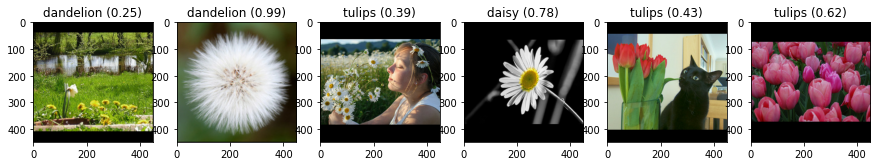

In [21]:
serving_model = models.load_model('export/flowers_model')
input_images = [create_preproc_image(f) for f in GS_FILES]
_, ax = plt.subplots(1, 6, figsize=(15, 15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()))
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    preproc_image = data_augmentation(batch_image)
    batch_pred = serving_model.predict(preproc_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title(f'{pred_label} ({prob:.2f})')

In [25]:
filenames = tf.convert_to_tensor(GS_FILES)
input_images = tf.map_fn( 
    create_preproc_image,
    filenames,
    fn_output_signature=tf.float32
)
input_images = data_augmentation(input_images)

batch_pred = serving_model.predict(input_images)
print('full probs:\n', batch_pred)

top_prob = tf.math.reduce_max(batch_pred, axis=[1])
print(f'Top prob:\n {top_prob}')

pred_label_index = tf.math.argmax(batch_pred, axis=1)
print(f'top class:\n{pred_label_index}')

pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES), pred_label_index)
print(pred_label)

1/1 [==============================] - 0s 331ms/step
full probs:
 [[0.22946852 0.24648134 0.19009328 0.20125575 0.13270119]
 [0.00331316 0.98833627 0.00256755 0.00171534 0.0040677 ]
 [0.0761488  0.03791603 0.18074062 0.3151455  0.39004904]
 [0.77779603 0.08639587 0.0353049  0.09053597 0.00996714]
 [0.08459473 0.06125543 0.23026593 0.19363308 0.43025082]
 [0.07621207 0.01812278 0.18148059 0.10035394 0.6238307 ]]
Top prob:
 [0.24648134 0.98833627 0.39004904 0.77779603 0.43025082 0.6238307 ]
top class:
[1 1 4 0 4 4]
tf.Tensor([b'dandelion' b'dandelion' b'tulips' b'daisy' b'tulips' b'tulips'], shape=(6,), dtype=string)


In [27]:
@tf.function(input_signature=[tf.TensorSpec([None,], dtype=tf.string)])
def predict_flower_type(filenames):
    input_images = tf.map_fn(
        create_preproc_image,
        filenames,
        fn_output_signature=tf.float32
    )
    preproc_images = data_augmentation(input_images)
    batch_pred = model(preproc_images)
    top_prob = tf.math.reduce_max(batch_pred, axis=[1])
    pred_label_index = tf.math.argmax(batch_pred, axis=1)
    pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES), pred_label_index)
    return {
        'probability': top_prob,
        'flower_type_int': pred_label_index,
        'flower_type_str': pred_label
    }

In [28]:
shutil.rmtree("export", ignore_errors=True)
os.mkdir("export")
model.save("export/flowers_model", signatures={"serving_default": predict_flower_type})


INFO:tensorflow:Assets written to: export/flowers_model/assets


INFO:tensorflow:Assets written to: export/flowers_model/assets


In [30]:
serving_fn = models.load_model('export/flowers_model').signatures['serving_default']
pred = serving_fn(tf.convert_to_tensor(GS_FILES))
print(pred)
print('******')
print(pred['flower_type_str'].numpy())

{'flower_type_int': <tf.Tensor: shape=(6,), dtype=int64, numpy=array([1, 1, 4, 0, 4, 4])>, 'flower_type_str': <tf.Tensor: shape=(6,), dtype=string, numpy=
array([b'dandelion', b'dandelion', b'tulips', b'daisy', b'tulips',
       b'tulips'], dtype=object)>, 'probability': <tf.Tensor: shape=(6,), dtype=float32, numpy=
array([0.24648134, 0.98833627, 0.39004904, 0.77779603, 0.43025082,
       0.6238307 ], dtype=float32)>}
******
[b'dandelion' b'dandelion' b'tulips' b'daisy' b'tulips' b'tulips']


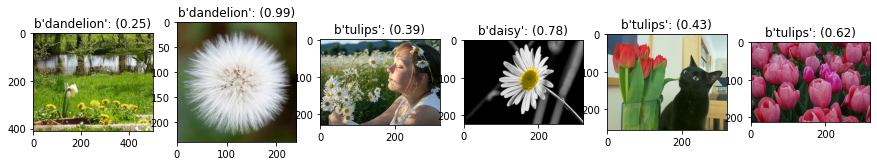

In [32]:
_, ax = plt.subplots(1, 6, figsize=(15, 15))
for idx, (filename, prob, pred_label) in enumerate(
    zip(filenames, pred['probability'].numpy(), pred['flower_type_str'].numpy())
):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title(f'{str(pred_label)}: ({prob:.2f})')

## Save the model to Google Cloud Storage

In [33]:
%%bash
PROJECT = $(gcloud config get-value project)

gsutil cp -r export/flowers_model gs://mmenendezg-ml-bucket/models/flowers_model

bash: line 1: PROJECT: command not found
Copying file://export/flowers_model/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://export/flowers_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://export/flowers_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://export/flowers_model/variables/variables.index [Content-Type=application/octet-stream]...
| [4 files][ 10.9 MiB/ 10.9 MiB]  566.0 KiB/s                                   
Operation completed over 4 objects/10.9 MiB.                                     
